In [1]:
# importing relevant modules
import matplotlib.pyplot   as plt

from pandas                import read_csv, to_datetime
from numpy                 import reshape
from datetime              import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models          import Sequential
from keras.layers          import Dense, Dropout, LSTM

%matplotlib inline

Using TensorFlow backend.


In [2]:
# Currency conversion.
Yen_To_USD = lambda p: p*0.0094

In [3]:
# Import the dataset and encode the date
dataFiles     = ['bitflyerJPY_1-min_data_2017-07-04_to_2018-03-27.csv', 'coinbaseUSD_1-min_data_2014-12-01_to_2018-03-27.csv',
                 'coincheckJPY_1-min_data_2014-10-31_to_2018-03-27.csv', 'bitstampUSD_1-min_data_2012-01-01_to_2018-03-27.csv']
file          = 0
df            = read_csv('../data/' + dataFiles[file])
# Append 'date' column to our dataframe.
df['date']    = to_datetime(df['Timestamp'],unit='s').dt.date
# Store the average weighted price per day.
daily_average = [df.groupby('date')['Weighted_Price'].mean().apply(Yen_To_USD), df.groupby('date')['Weighted_Price'].mean()][file%2]

We will now perform min-max normalization on the training data and then construct an LSTM network to make predictions for the remainder of our data. After this, we will compare our model's predicted price values to that of the testing data set.

In [4]:
# Form training set from daily averages.
#training_set = df_train.values
training_set = daily_average.values
training_set = reshape(training_set, (len(training_set), 1))

# Perform Min-max normalization.
sc           = MinMaxScaler()
training_set = sc.fit_transform(training_set)

# Create two new arrays, x is a day behind y.
x_train      = training_set[:-1]
y_train      = training_set[1:]
x_train      = reshape(x_train, (len(x_train), 1, 1))

In [5]:
# Building the model
lstm_units = 100
model      = Sequential()

model.add(LSTM(units            = lstm_units,
               return_sequences = True,
               input_shape      = (None, 1)))

model.add(Dropout(0.2))
    
model.add(LSTM(units            = lstm_units,
               return_sequences = False))

model.add(Dropout(0.2))

model.add(Dense(units      = 1,
                activation = 'linear'))

model.compile(loss      = 'mean_squared_error',
              optimizer = 'rmsprop')

model.summary()

# Fitting the RNN to the Training set
history = model.fit(x          = x_train,
                    y          = y_train,
                    batch_size = len(x_train),
                    epochs     = 100,
                    verbose    = 0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 100)         40800     
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Predicting the future.
#actual_prices       = df_test.values
actual_prices       = sc.inverse_transform(y_train)
predicted_BTC_price = sc.inverse_transform(model.predict(x_train))
print(len(predicted_BTC_pr), len(y_train))

264 264


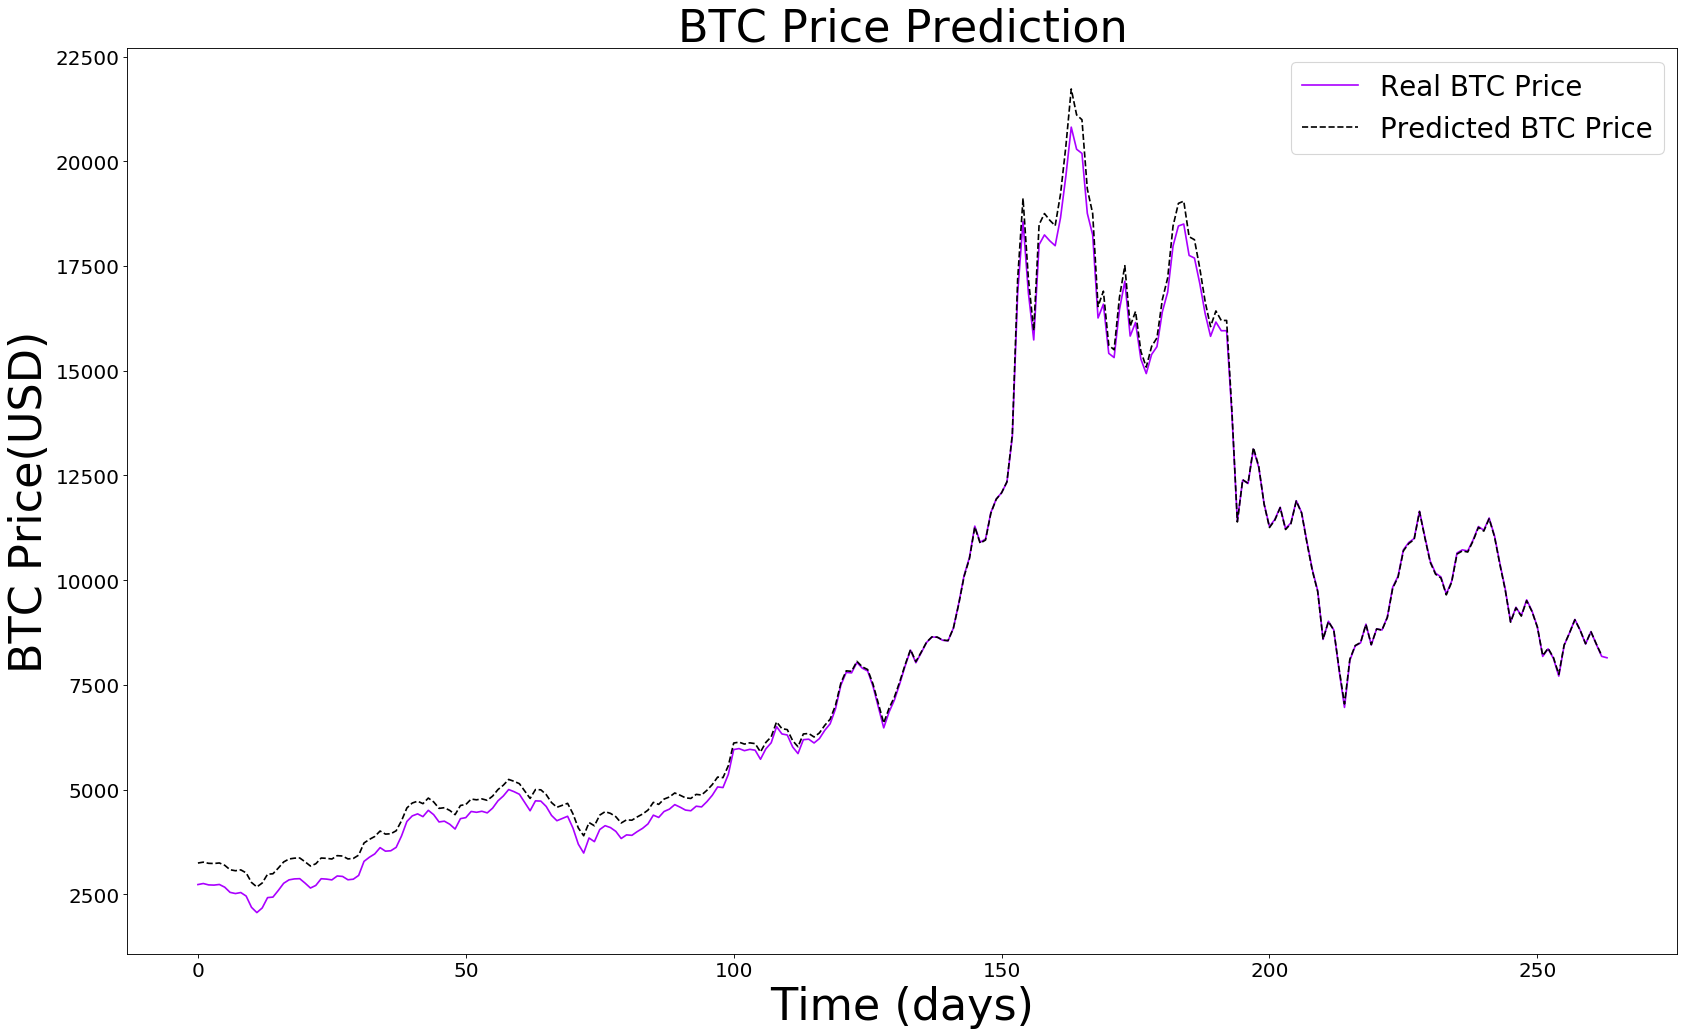

In [10]:
# Visualising the results
plt.figure(figsize   = (25,15),
           dpi       = 80,
           facecolor = 'w',
           edgecolor = 'k')

ax      = plt.gca()

plt.plot(actual_prices, 
         color = '#AA00FF',
         label = 'Real BTC Price')
plt.plot(predicted_BTC_price[1:],
         color = '#000000',
         ls    = 'dashed',
         label = 'Predicted BTC Price')

plt.title('BTC Price Prediction',
          fontsize = 40)

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
    
plt.xlabel('Time (days)',
           fontsize = 40)
plt.ylabel('BTC Price(USD)',
           fontsize = 40)
plt.legend(loc  = 'best',
           prop = {'size': 25})

plt.show()

Even more interesting than looking at the average daily price prediction is looking at the predicted average daily price percent change as compared to that of the actual average daily price percent change; we will do this below.

In [8]:
predicted_percent_change = [100*(e2[0] - e1[0])/e1[0] for e1, e2 in zip(predicted_BTC_price[:-1], predicted_BTC_price[1:])]
actual_percent_change    = [100*(e2 - e1)/e1 for e1, e2 in zip(actual_prices[:-1], actual_prices[1:])]

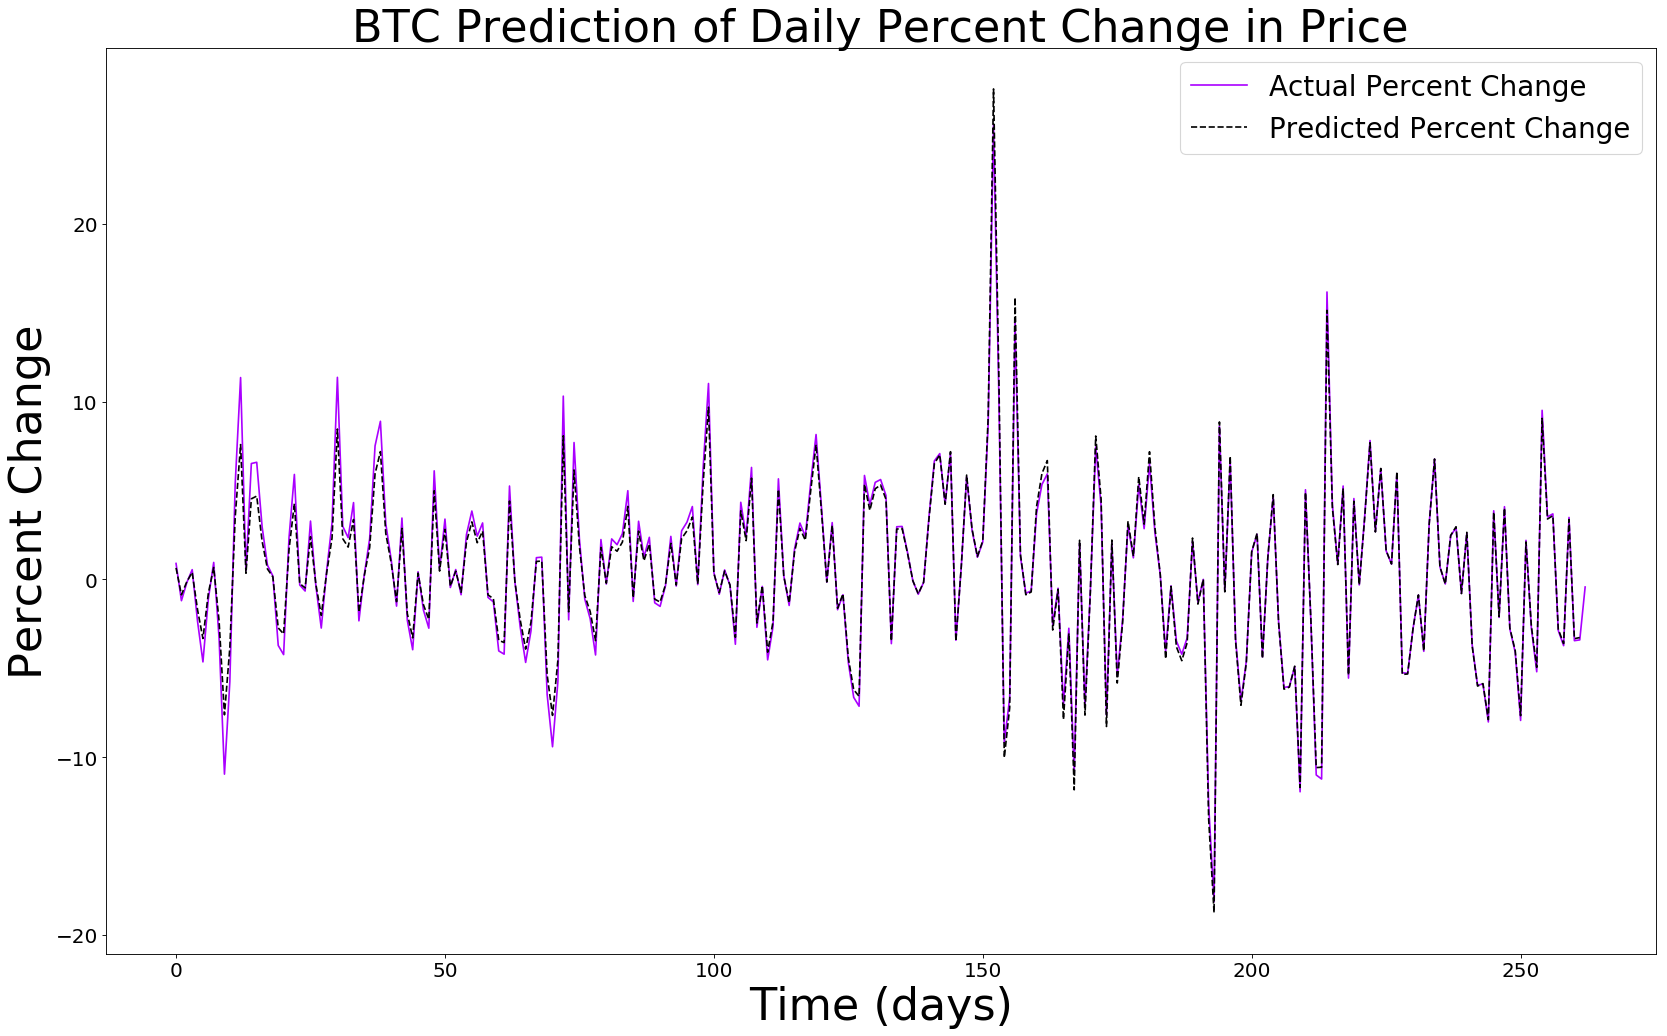

In [11]:
plt.figure(figsize   = (25,15),
           dpi       = 80,
           facecolor = 'w',
           edgecolor = 'k')

ax      = plt.gca()

plt.plot(actual_percent_change, 
         color = '#AA00FF',
         label = 'Actual Percent Change')
plt.plot(predicted_percent_change[1:],
         color = '#000000',
         ls    = 'dashed',
         label = 'Predicted Percent Change')

plt.title('BTC Prediction of Daily Percent Change in Price',
          fontsize = 40)

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
    
plt.xlabel('Time (days)',
           fontsize = 40)
plt.ylabel('Percent Change',
           fontsize = 40)
plt.legend(loc  = 'best',
           prop = {'size': 25})

plt.show()